## Topic Modelling

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from gsdmm import MovieGroupProcess
import json

import nltk
from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
from gensim.utils import simple_preprocess
import gensim, spacy
from gensim.models.ldamulticore import LdaMulticore
import re

from gensim.models import Phrases
from gensim.models.phrases import Phraser

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from collections import Counter

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Imaji
[nltk_data]     Kasih\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# path to the directory where JSON files ae
post_dir = Path('./test_archive_openrndr/posts')
data = []

# iterate through all JSON files in the directory
for json_file in post_dir.glob('**/*.json'):
    with open(json_file, 'r') as f:
        post_data = json.load(f)
        data.append(post_data)

df = pd.DataFrame(data)

### Preprocessing

In [4]:
# dropping (possible) irrelevant columns
df = df.drop(['name', 'username', 'avatar_template', 
              'yours', 'topic_html_title', 'display_username', 
              'flair_name', 'flair_url', 'flair_bg_color', 
              'flair_color', 'flair_group_id',
              'can_edit', 'can_delete', 'can_recover',
              'can_see_hidden_post', 'can_wiki',
              'bookmarked', 'moderator', 'admin',
              'staff', 'hidden', 'user_deleted',
              'edit_reason', 'can_view_edit_history',
              'wiki', 'current_user_reaction',
              'current_user_used_main_reaction',
              'via_email', 'primary_group_name',
              'can_accept_answer', 'can_unaccept_answer'], axis=1)

In [5]:
df.describe()

id  post_number  post_type  reply_count  reply_to_post_number  \
count  1255.000000  1255.000000     1255.0  1255.000000            507.000000   
mean   1048.927490    18.075697        1.0     0.407968             17.893491   
std     583.635644    38.512677        0.0     0.542544             36.674733   
min       1.000000     1.000000        1.0     0.000000              1.000000   
25%     507.500000     2.000000        1.0     0.000000              3.000000   
50%    1086.000000     4.000000        1.0     0.000000              5.000000   
75%    1565.500000     9.000000        1.0     1.000000              9.500000   
max    2015.000000   189.000000        1.0     3.000000            178.000000   

       quote_count  incoming_link_count        reads  readers_count  \
count  1255.000000          1255.000000  1255.000000    1255.000000   
mean      0.015936            22.972112    14.764940      13.764940   
std       0.125279           139.879539    10.122049      10.122049   
min       0.000000             0.000000     1.000000       0.000000   
25%       0.000000             0.000000     8.000000       7.000000   
50%       0.000000             1.000000    12.000000      11.000000   
75%       0.000000             4.000000    18.000000      17.000000   
max       1.000000          2760.000000    74.000000      73.000000   

              score     topic_id  category_id      version      user_id  \
count   1255.000000  1255.000000  1255.000000  1255.000000  1255.000000   
mean     141.856414   306.857371     8.282072     1.367331    40.835857   
std      701.744433   208.809627     3.801719     0.843240    49.946049   
min        0.200000     1.000000     1.000000     1.000000    -1.000000   
25%        7.400000    99.000000     7.000000     1.000000     6.000000   
50%       22.600000   303.000000     8.000000     1.000000     6.000000   
75%       68.800000   503.000000    11.000000     1.000000    87.000000   
max    13771.600000   677.000000    18.000000    11.000000   176.000000   

       trust_level  reaction_users_count  
count  1255.000000           1255.000000  
mean      2.784064              0.822311  
std       1.403596              1.248085  
min       0.000000              0.000000  
25%       1.000000              0.000000  
50%       4.000000              0.000000  
75%       4.000000              1.000000  
max       4.000000              8.000000

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at']) 

In [7]:
df['post_length'] = df['raw'].apply(lambda x: len(x.split()))

print('Mean length:', df['post_length'].mean())

Mean length: 102.0414342629482


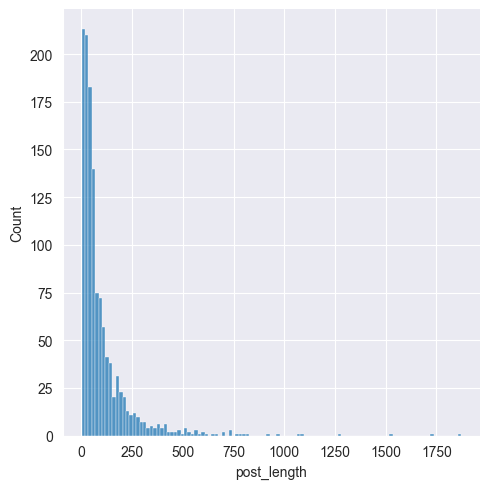

In [8]:
sns.set_style(style='darkgrid')
sns.displot(df['post_length'])

In [9]:
df['raw']

0       Discussion about this site, its organization, ...
1       OPENRNDR is an opensource framework for creati...
2       I guess "Site Feedback" is the "Meta" category...
3       I don't know how much we can change on the hos...
4       `How to?` sounds OK,  or the bit more specific...
                              ...                        
1250    ![contour.Adjust04-2024-09-01-17.10.40|640x480...
1251    I've been working on an implementation of [Con...
1252    ## Code-generated SVG files for pen plotters\n...
1253    Thank you for sharing and welcome to the forum...
1254    Hi @abe 👋 thanks for taking a look and the tho...
Name: raw, Length: 1255, dtype: object

In [10]:
df['raw_list'] = df['raw'].values.tolist()

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # only tokenization enabled
code_pattern = r'```(.*?)```'  # Regex to extract code blocks

def process_raw_list(text):
    code_blocks = re.findall(code_pattern, text, flags=re.DOTALL)
    reg_text = re.sub(code_pattern, '', text) # remove code blocks from the text
    clean_text = re.sub(r'\s+', ' ', reg_text) # clean excess whitespace
    return clean_text, code_blocks

In [12]:
df['raw_processed'] = df['raw_list'].apply(lambda x: process_raw_list(x))

In [13]:
def tokenize_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

In [14]:
df['raw_tokens'] = df['raw_processed'].apply(lambda x: tokenize_text(x[0]))

In [15]:
def remove_stopwords(text):
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]

In [16]:
df['raw_tokens_wosw'] = remove_stopwords(df['raw_tokens'])

In [17]:
def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in text:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
df['raw_tokens_lemma'] = lemmatization(df['raw_tokens_wosw'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [19]:
print(df['raw_tokens_lemma'])

0         [discussion, site, organization, work, improve]
1       [framework, creative, code, find, place, discu...
2       [guess, site, feedback, meta, category, discus...
3       [know, change, host, version, discourse, hope,...
4              [sound, bit, specific, openrndr, question]
                              ...                        
1250    [contour, adjust, play, contour, start, square...
1251    [ve, work, implementation, conway, game, life,...
1252    [generate, svg, file, pen, plotter, recent, se...
1253    [thank, share, run, mesmerize, evolve, random,...
1254    [thank, take, look, thought, idea, paint, sort...
Name: raw_tokens_lemma, Length: 1255, dtype: object


In [20]:
# new
df.to_csv('processedraw_data.csv', index=False)

### Model | GSDMM

In [22]:
df['category_id'].nunique()

14

In [23]:
np.random.seed(0)

In [24]:
mgp = MovieGroupProcess(K=10, alpha=0.01, beta=0.01, n_iters=30)
vocab = set(x for content in df['raw_tokens_lemma'] for x in content)
n_terms = len(vocab)
model = mgp.fit(df['raw_tokens_lemma'], n_terms)

In stage 0: transferred 1043 clusters with 10 clusters populated
In stage 1: transferred 525 clusters with 10 clusters populated
In stage 2: transferred 285 clusters with 10 clusters populated
In stage 3: transferred 203 clusters with 10 clusters populated
In stage 4: transferred 176 clusters with 10 clusters populated
In stage 5: transferred 140 clusters with 10 clusters populated
In stage 6: transferred 136 clusters with 10 clusters populated
In stage 7: transferred 136 clusters with 10 clusters populated
In stage 8: transferred 133 clusters with 10 clusters populated
In stage 9: transferred 125 clusters with 10 clusters populated
In stage 10: transferred 131 clusters with 10 clusters populated
In stage 11: transferred 131 clusters with 10 clusters populated
In stage 12: transferred 128 clusters with 10 clusters populated
In stage 13: transferred 120 clusters with 10 clusters populated
In stage 14: transferred 97 clusters with 10 clusters populated
In stage 15: transferred 116 cluste

In [25]:
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(),
                            key=lambda k: k[1], reverse=True)[:values]
        print('\ncluster %s : %s'%(cluster, sort_dicts))

In [26]:
doc_count = np.array(mgp.cluster_doc_count)
print('number of documents per topic:', doc_count)

top_index = doc_count.argsort()[-10:][::-1]
print('\nmost important clusters - by number of docs inside:', top_index)

# show the top 5 words in term frequency for each cluster
top_words(mgp.cluster_word_distribution, top_index, 10)

number of documents per topic: [ 39  14 419  19   8  95 190  13  10 448]

most important clusters - by number of docs inside: [9 2 6 5 0 3 1 7 8 4]

cluster 9 : [('drawer', 856), ('org', 659), ('import', 467), ('draw', 466), ('user', 401), ('program', 385), ('shape', 377), ('application', 361), ('jar', 354), ('fun', 336)]

cluster 2 : [('thank', 102), ('use', 99), ('work', 95), ('com', 76), ('think', 75), ('code', 75), ('video', 72), ('look', 70), ('find', 68), ('shader', 67)]

cluster 6 : [('template', 72), ('project', 60), ('work', 55), ('version', 50), ('build', 48), ('gradle', 48), ('run', 44), ('file', 42), ('change', 41), ('thank', 41)]

cluster 5 : [('run', 60), ('gradle', 57), ('work', 41), ('build', 40), ('try', 35), ('version', 29), ('window', 26), ('example', 24), ('application', 22), ('main', 21)]

cluster 0 : [('com', 40), ('https', 12), ('video', 10), ('instagram', 9), ('www', 7), ('twitter', 7), ('status', 7), ('coart', 7), ('photo', 6), ('upload', 5)]

cluster 3 : [('co

In [27]:
topic_dict = {}
topic_names = ['cat 1', 'cat 2', 'cat 3', 'cat 4', 'cat 5',
               'cat 6', 'cat 7', 'cat 8', 'cat 9', 'cat 10']

for i, topic_num in enumerate(top_index):
    topic_dict[topic_num] = topic_names[i]

In [28]:
def create_topics_df(data_text=df['raw'], mgp=mgp, threshold=0.3, topic_dict=topic_dict, lemma_text=df['raw_tokens_lemma']):
    result = pd.DataFrame(columns=['content', 'gen_category', 'og_category', 'lemma_content'])
    for i, text in enumerate(data_text):
        result.at[i, 'content'] = text
        result.at[i, 'og_category'] = df['category_id'][i]
        result.at[i, 'lemma_content'] = df['raw_tokens_lemma'][i]
        prob = mgp.choose_best_label(df['raw_tokens_lemma'][i])

        if prob[1] >= threshold:
            result.at[i, 'gen_category'] = topic_dict[prob[0]]
        else:
            result.at[i, 'gen_category'] = 'Other'
    return result

In [29]:
result = create_topics_df()

In [30]:
result.head()

content gen_category og_category  \
0  Discussion about this site, its organization, ...        cat 2           2   
1  OPENRNDR is an opensource framework for creati...        cat 3           1   
2  I guess "Site Feedback" is the "Meta" category...        cat 2           2   
3  I don't know how much we can change on the hos...        cat 3           2   
4  `How to?` sounds OK,  or the bit more specific...        cat 2           2   

                                       lemma_content  
0    [discussion, site, organization, work, improve]  
1  [framework, creative, code, find, place, discu...  
2  [guess, site, feedback, meta, category, discus...  
3  [know, change, host, version, discourse, hope,...  
4         [sound, bit, specific, openrndr, question]

### Visualization | GSDMM

In [31]:
import plotly.offline as pyo
pyo.init_notebook_mode() 

In [32]:
fig = px.pie(result, names='gen_category', title='categories', color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [33]:
fig = px.sunburst(result, path=['gen_category', 'og_category'], title='original vs generated categories',
                  color_discrete_sequence=px.colors.sequential.Burg)
fig.show()

In [34]:
result['len'] = result['content'].apply(lambda row: len(row.split()))
result.head()

content gen_category og_category  \
0  Discussion about this site, its organization, ...        cat 2           2   
1  OPENRNDR is an opensource framework for creati...        cat 3           1   
2  I guess "Site Feedback" is the "Meta" category...        cat 2           2   
3  I don't know how much we can change on the hos...        cat 3           2   
4  `How to?` sounds OK,  or the bit more specific...        cat 2           2   

                                       lemma_content  len  
0    [discussion, site, organization, work, improve]   15  
1  [framework, creative, code, find, place, discu...   29  
2  [guess, site, feedback, meta, category, discus...  154  
3  [know, change, host, version, discourse, hope,...   47  
4         [sound, bit, specific, openrndr, question]   11

In [35]:
result.dtypes

content          object
gen_category     object
og_category      object
lemma_content    object
len               int64
dtype: object

In [36]:
result['len'] = pd.to_numeric(result['len'], errors='coerce')

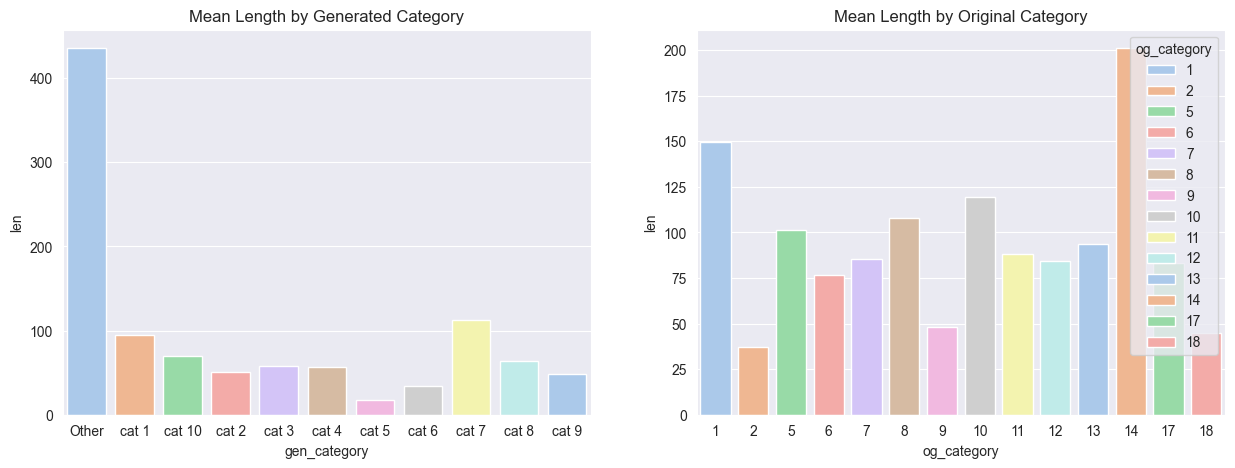

In [37]:
gen_cat_len = result.groupby(by=['gen_category'])['len'].mean().reset_index()
og_cat_len = result.groupby(by=['og_category'])['len'].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Mean Length by Generated Category')
ax[1].set_title('Mean Length by Original Category')

sns.barplot(x='gen_category', y='len', data=gen_cat_len, hue='gen_category', palette='pastel', ax=ax[0])
sns.barplot(x='og_category', y='len', data=og_cat_len, hue='og_category', palette='pastel', ax=ax[1])

plt.show()

In [38]:
result['lemma_content'] = result['lemma_content'].apply(lambda row: ' '.join(row))

In [39]:
from wordcloud import WordCloud

In [40]:
def create_wc(data, title=None):
    wc = WordCloud(width=500, height=500,
                   background_color='white',
                   min_font_size=15).generate(' '.join(data.values))
    
    plt.figure(figsize=(5,5), facecolor=None)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

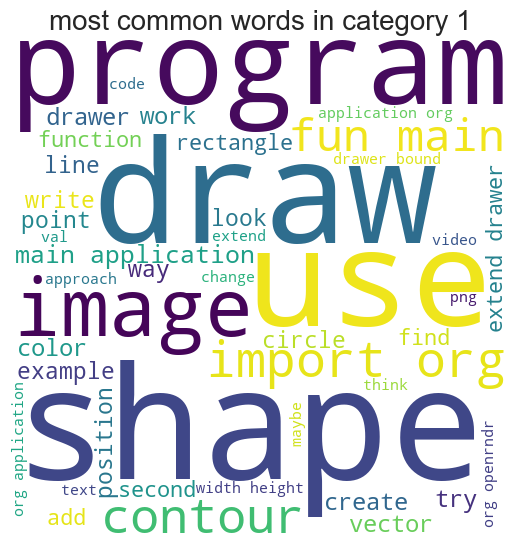

In [41]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 1'], 
          title='most common words in category 1')

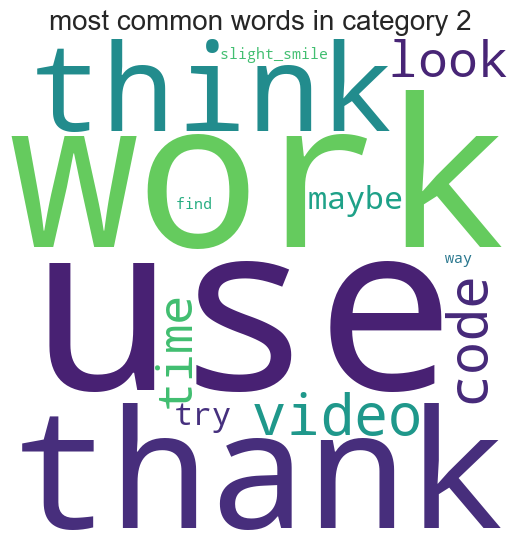

In [42]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 2'], 
          title='most common words in category 2')

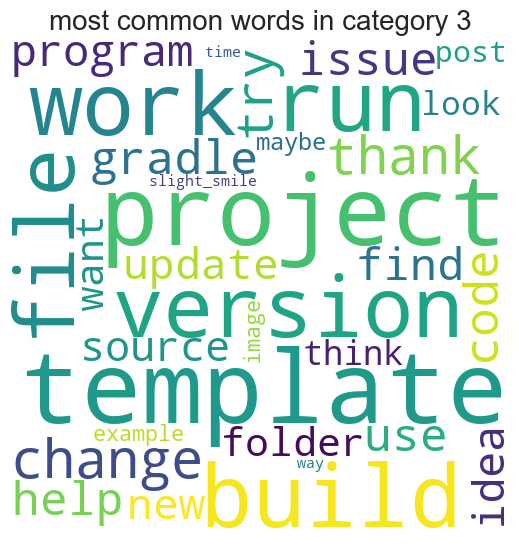

In [43]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 3'], 
          title='most common words in category 3')

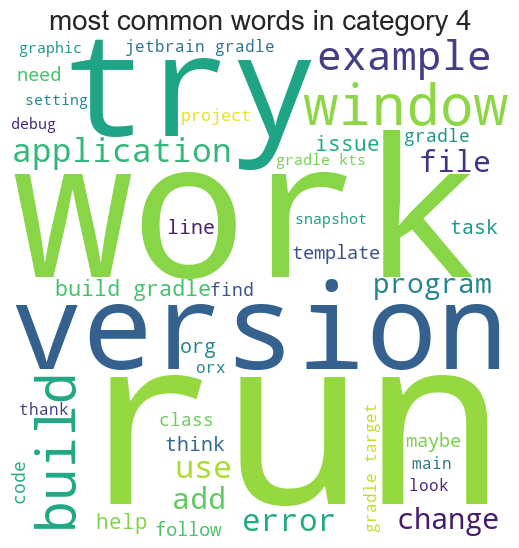

In [44]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 4'], 
          title='most common words in category 4')

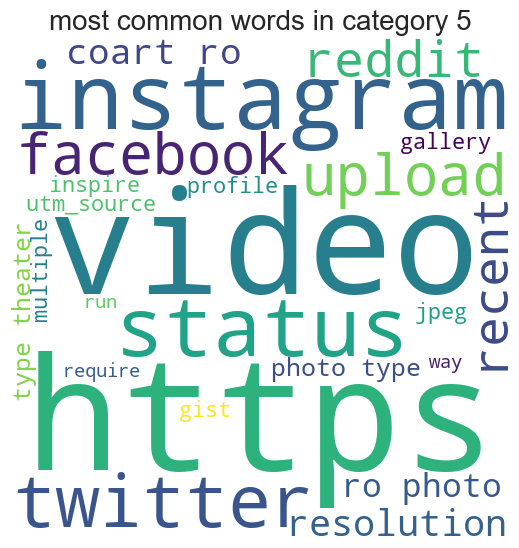

In [45]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 5'], 
          title='most common words in category 5')

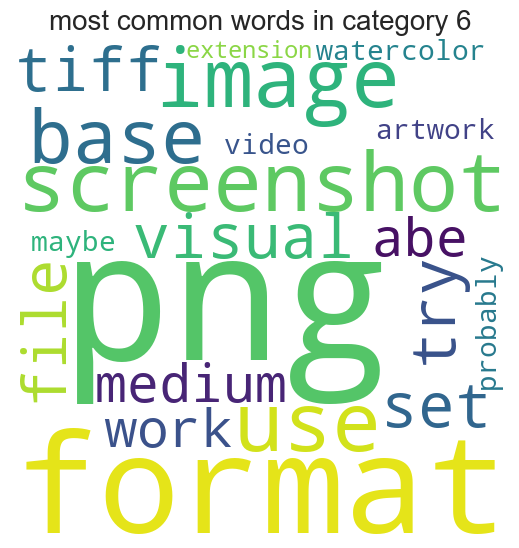

In [46]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 6'], 
          title='most common words in category 6')

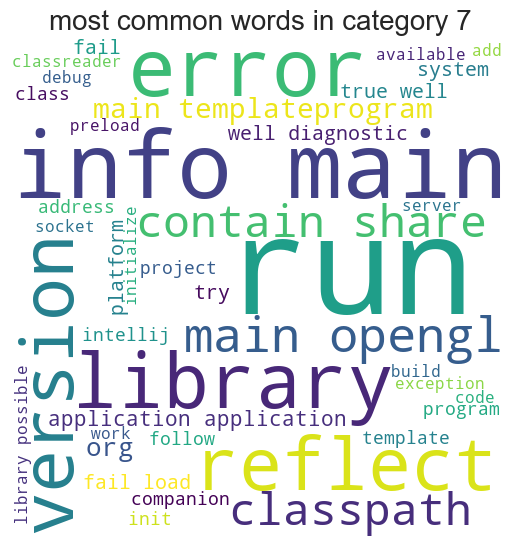

In [47]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 7'], 
          title='most common words in category 7')

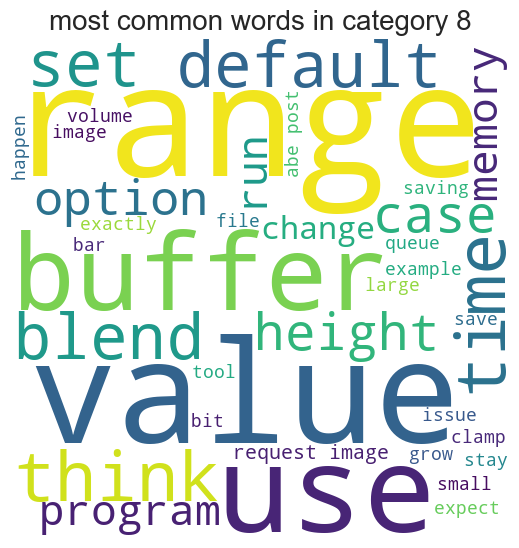

In [48]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 8'], 
          title='most common words in category 8')

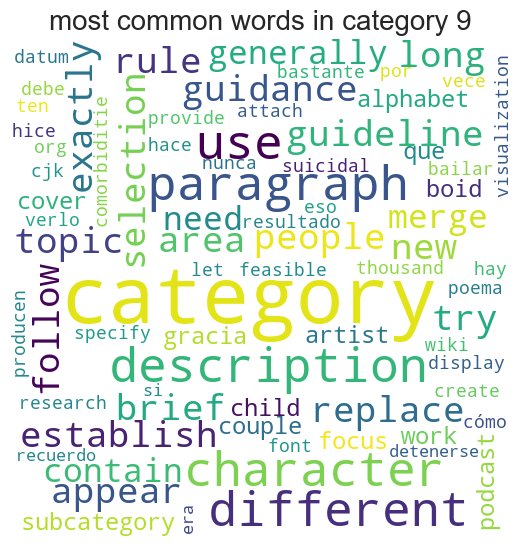

In [49]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 9'], 
          title='most common words in category 9')

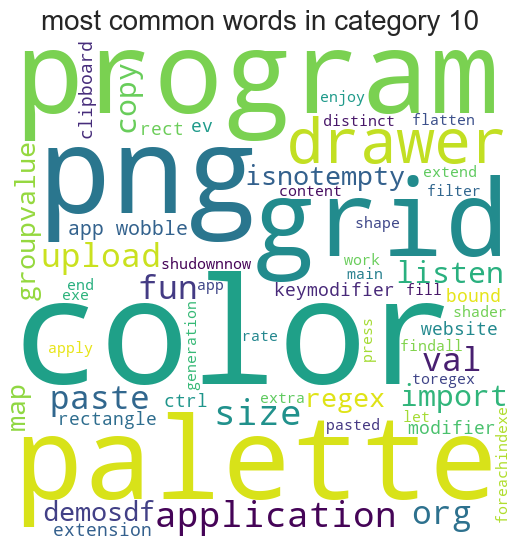

In [50]:
create_wc(result['lemma_content'].loc[result['gen_category'] == 'cat 10'], 
          title='most common words in category 10')

### Model | LDA

In [51]:
id2word = corpora.Dictionary(df['raw_tokens_lemma'])
texts = df['raw_tokens_lemma']
corpus = [id2word.doc2bow(text) for text in texts]

In [52]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [53]:
from gensim.models.ldamulticore import LdaMulticore

def calc_coherence_values(dictionary, corpus, texts, limit=12, start=1, step=1):
    # parameters
    '''
    dictionary: The Gensim Dictionary object mapping words to IDs.
    corpus: The corpus of documents in bag-of-words or TF-IDF format.
    texts: The tokenized text data.
    limit: The maximum number of topics to consider.
    start: The starting number of topics.
    step: The step size to increment the number of topics.
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=.1, eta=0.1, random_state=42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [54]:
model_list, coherence_values = calc_coherence_values(dictionary=id2word, corpus=corpus_tfidf, texts=texts, start=2, limit=16, step=2)

model created
0.42770378418023214
model created
0.42121012743914793
model created
0.44197896254467084
model created
0.4042340464006673
model created
0.393032867300347
model created
0.3956825856191832
model created
0.4019704081035873


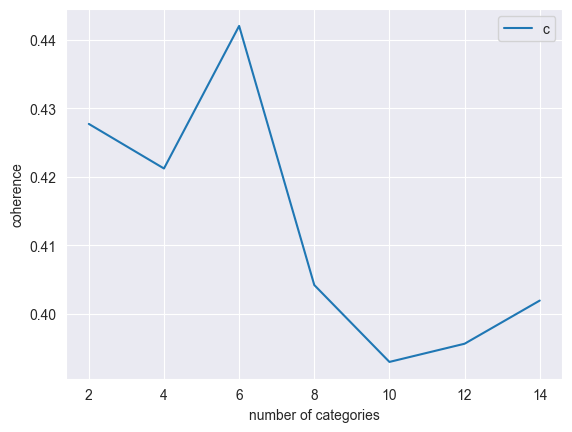

In [55]:
limit, start, step = 16, 2, 2
x_range = range(start, limit, step)
plt.plot(x_range, coherence_values)
plt.xlabel('number of categories')
plt.ylabel('coherence')
plt.legend(('coherence_values'), loc='best')
plt.show() # best is 6

In [56]:
index = coherence_values.index(max(coherence_values))
model_list[index].show_topics()

[(0,
  '0.004*"drawer" + 0.003*"work" + 0.003*"org" + 0.003*"issue" + 0.003*"build" + 0.003*"think" + 0.003*"thank" + 0.003*"draw" + 0.003*"import" + 0.003*"program"'),
 (1,
  '0.004*"nice" + 0.003*"try" + 0.003*"png" + 0.003*"look" + 0.003*"write" + 0.003*"gradle" + 0.003*"use" + 0.003*"code" + 0.003*"image" + 0.002*"work"'),
 (2,
  '0.003*"run" + 0.003*"code" + 0.003*"thank" + 0.003*"work" + 0.003*"main" + 0.003*"issue" + 0.003*"video" + 0.002*"program" + 0.002*"org" + 0.002*"shader"'),
 (3,
  '0.005*"thank" + 0.005*"drawer" + 0.003*"shape" + 0.003*"contour" + 0.003*"version" + 0.003*"post" + 0.003*"draw" + 0.003*"run" + 0.003*"try" + 0.003*"template"'),
 (4,
  '0.004*"com" + 0.003*"video" + 0.003*"shader" + 0.003*"work" + 0.003*"drawer" + 0.003*"try" + 0.003*"slight_smile" + 0.003*"org" + 0.002*"https" + 0.002*"program"'),
 (5,
  '0.006*"thank" + 0.003*"work" + 0.003*"drawer" + 0.003*"try" + 0.003*"use" + 0.003*"share" + 0.003*"think" + 0.003*"good" + 0.003*"look" + 0.002*"template"

In [57]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim_models.prepare(model_list[index], corpus_tfidf, id2word, sort_topics=False, n_jobs=1)
pyLDAvis.display(lda_display)

In [58]:
def format_topics_sentences(lda_model, corpus, data):
    # Initialize an empty DataFrame with the specified columns
    sent_topics_df = pd.DataFrame(columns=['dominant_topic', '(%) contribution', 'topic keywords'])

    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row, key=lambda x: x[1], reverse=True)  # Sort by topic contribution
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in wp])
                
                # Create a Series for the current row
                new_row = pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords], 
                                    index=['dominant_topic', '(%) contribution', 'topic keywords'])
                
                # Use pd.concat to add the new row to the DataFrame
                sent_topics_df = pd.concat([sent_topics_df, new_row.to_frame().T], ignore_index=True)
            else:
                break

    # Append the original texts as a new column
    contents = pd.Series(data)  # Use 'data' parameter for contents instead of 'texts'
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('text')], axis=1)

    return sent_topics_df


In [59]:
df_topic_sent_keywords = format_topics_sentences(model_list[index], corpus_tfidf, texts)

df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['doc_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

df_dominant_topic.head()

doc_no dominant_topic topic_perc_contrib  \
0       0              5             0.8144   
1       1              1             0.8683   
2       2              2             0.8108   
3       3              0             0.8699   
4       4              5             0.8206   

                                            keywords  \
0  thank, work, drawer, try, use, share, think, g...   
1  nice, try, png, look, write, gradle, use, code...   
2  run, code, thank, work, main, issue, video, pr...   
3  drawer, work, org, issue, build, think, thank,...   
4  thank, work, drawer, try, use, share, think, g...   

                                                text  
0    [discussion, site, organization, work, improve]  
1  [framework, creative, code, find, place, discu...  
2  [guess, site, feedback, meta, category, discus...  
3  [know, change, host, version, discourse, hope,...  
4         [sound, bit, specific, openrndr, question]

In [60]:
topic_counts = df_dominant_topic['dominant_topic'].value_counts().sort_values(ascending=True)
topic_counts

dominant_topic
4    158
2    204
3    216
5    219
1    220
0    238
Name: count, dtype: int64

## Sentiment Analysis

In [61]:
df.columns

Index(['id', 'created_at', 'cooked', 'post_number', 'post_type', 'updated_at',
       'reply_count', 'reply_to_post_number', 'quote_count',
       'incoming_link_count', 'reads', 'readers_count', 'score', 'topic_id',
       'topic_slug', 'topic_title', 'category_id', 'version', 'user_title',
       'raw', 'actions_summary', 'user_id', 'trust_level', 'deleted_at',
       'reactions', 'reaction_users_count', 'accepted_answer',
       'topic_accepted_answer', 'reply_to_user', 'polls', 'post_length',
       'raw_list', 'raw_processed', 'raw_tokens', 'raw_tokens_wosw',
       'raw_tokens_lemma'],
      dtype='object')

In [62]:
df.head()

id                       created_at  \
0   1 2019-10-30 10:56:34.234000+00:00   
1  10 2019-10-30 10:56:37.827000+00:00   
2  18 2019-10-30 18:00:51.533000+00:00   
3  19 2019-10-31 08:29:32.999000+00:00   
4  20 2019-10-31 08:32:44.782000+00:00   

                                              cooked  post_number  post_type  \
0  <p>Discussion about this site, its organizatio...            1          1   
1  <p>OPENRNDR is an opensource framework for cre...            1          1   
2  <p>I guess “Site Feedback” is the “Meta” categ...            1          1   
3  <p>I don’t know how much we can change on the ...            1          1   
4  <p><code>How to?</code> sounds OK,  or the bit...            2          1   

                        updated_at  reply_count  reply_to_post_number  \
0 2019-10-30 10:56:34.234000+00:00            0                   NaN   
1 2019-10-30 11:37:42.528000+00:00            0                   NaN   
2 2019-10-30 18:00:51.533000+00:00            0                   NaN   
3 2019-10-31 08:29:32.999000+00:00            0                   NaN   
4 2019-10-31 08:32:44.782000+00:00            0                   NaN   

   quote_count  incoming_link_count  ...  accepted_answer  \
0            0                    0  ...            False   
1            0                   18  ...            False   
2            0                    3  ...            False   
3            0                    0  ...            False   
4            0                    0  ...            False   

   topic_accepted_answer  reply_to_user  polls post_length  \
0                  False            NaN    NaN          15   
1                  False            NaN    NaN          29   
2                  False            NaN    NaN         154   
3                  False            NaN    NaN          47   
4                  False            NaN    NaN          11   

                                            raw_list  \
0  Discussion about this site, its organization, ...   
1  OPENRNDR is an opensource framework for creati...   
2  I guess "Site Feedback" is the "Meta" category...   
3  I don't know how much we can change on the hos...   
4  `How to?` sounds OK,  or the bit more specific...   

                                       raw_processed  \
0  (Discussion about this site, its organization,...   
1  (OPENRNDR is an opensource framework for creat...   
2  (I guess "Site Feedback" is the "Meta" categor...   
3  (I don't know how much we can change on the ho...   
4  (`How to?` sounds OK, or the bit more specific...   

                                          raw_tokens  \
0  [Discussion, about, this, site, ,, its, organi...   
1  [OPENRNDR, is, an, opensource, framework, for,...   
2  [I, guess, ", Site, Feedback, ", is, the, ", M...   
3  [I, do, n't, know, how, much, we, can, change,...   
4  [`, How, to, ?, `, sounds, OK, ,, or, the, bit...   

                                     raw_tokens_wosw  \
0   [discussion, site, organization, works, improve]   
1  [openrndr, opensource, framework, creative, co...   
2  [guess, site, feedback, meta, category, discus...   
3  [know, change, hosted, version, discourse, hop...   
4   [sounds, ok, bit, specific, openrndr, questions]   

                                    raw_tokens_lemma  
0    [discussion, site, organization, work, improve]  
1  [framework, creative, code, find, place, discu...  
2  [guess, site, feedback, meta, category, discus...  
3  [know, change, host, version, discourse, hope,...  
4         [sound, bit, specific, openrndr, question]  

[5 rows x 36 columns]

In [63]:
from textblob import TextBlob

In [64]:
# with textblob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment_tb'] = df['raw'].apply(get_sentiment)

C:\Users\Imaji Kasih\AppData\Local\Temp\ipykernel_6484\490647859.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




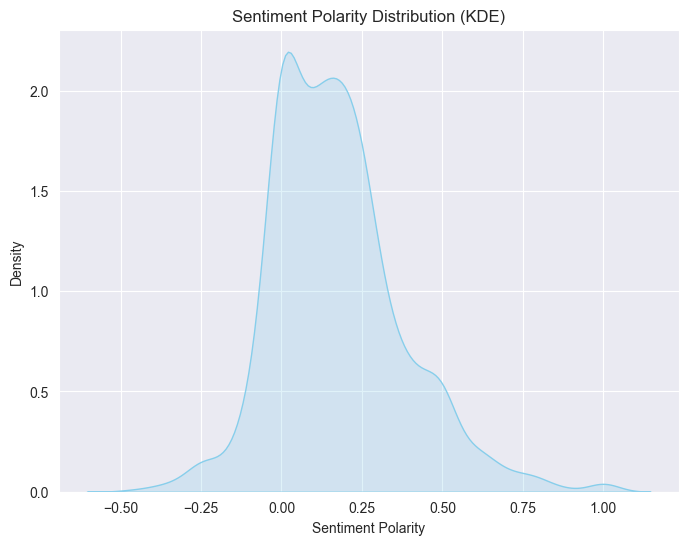

In [65]:
# KDE Plot for Sentiment Polarity
plt.figure(figsize=(8,6))
sns.kdeplot(df['sentiment_tb'], shade=True, color='skyblue')
plt.title('Sentiment Polarity Distribution (KDE)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Density')
plt.show()

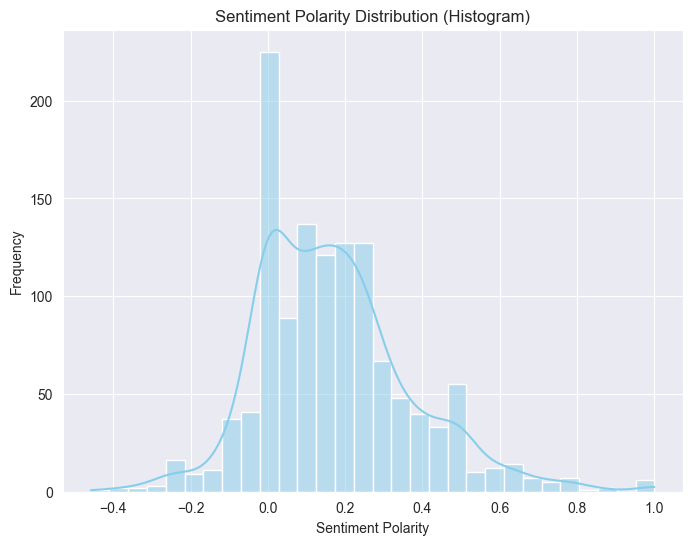

In [66]:
# Seaborn histogram
plt.figure(figsize=(8,6))
sns.histplot(df['sentiment_tb'], bins=30, kde=True, color='skyblue')
plt.title('Sentiment Polarity Distribution (Histogram)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

In [67]:
def categorize_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to create a sentiment category
df['sentiment_category'] = df['sentiment_tb'].apply(categorize_sentiment)

C:\Users\Imaji Kasih\AppData\Local\Temp\ipykernel_6484\3758284210.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




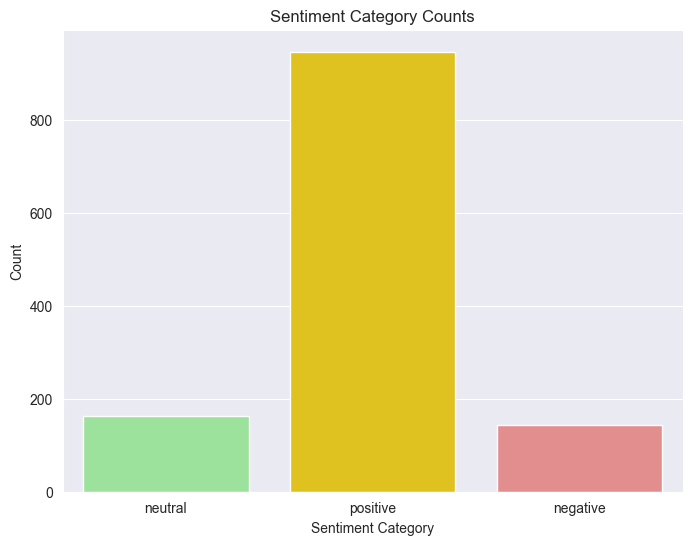

In [68]:
# sentiment category counts
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment_category', data=df, palette=['lightgreen', 'gold', 'lightcoral'])
plt.title('Sentiment Category Counts')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

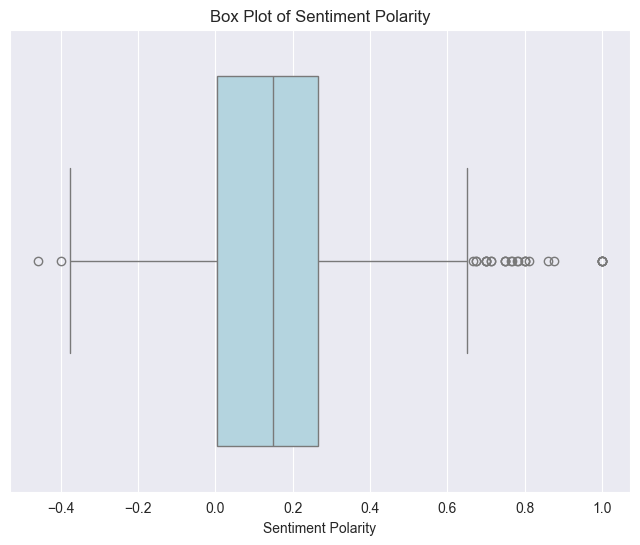

In [69]:
# box plot of sentiment polarity
plt.figure(figsize=(8,6))
sns.boxplot(x=df['sentiment_tb'], color='lightblue')
plt.title('Box Plot of Sentiment Polarity')
plt.xlabel('Sentiment Polarity')
plt.show()

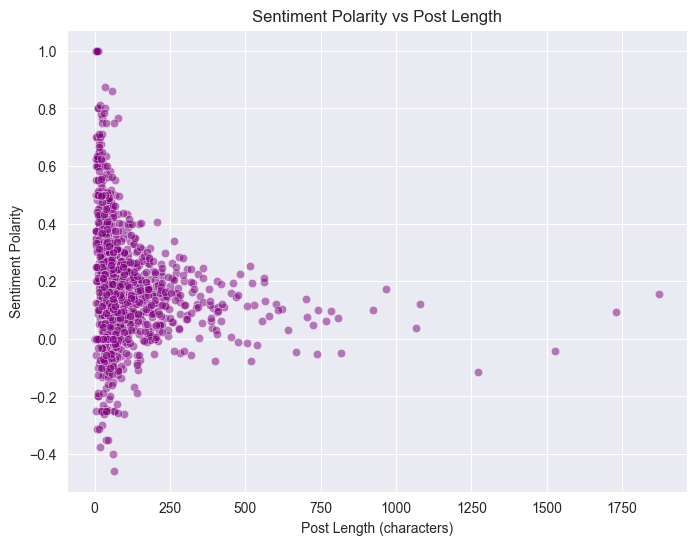

In [70]:
# scatter plot: post length vs sentiment polarity
plt.figure(figsize=(8,6))
sns.scatterplot(x='post_length', y='sentiment_tb', data=df, alpha=0.5, color='purple')
plt.title('Sentiment Polarity vs Post Length')
plt.xlabel('Post Length (characters)')
plt.ylabel('Sentiment Polarity')
plt.show()

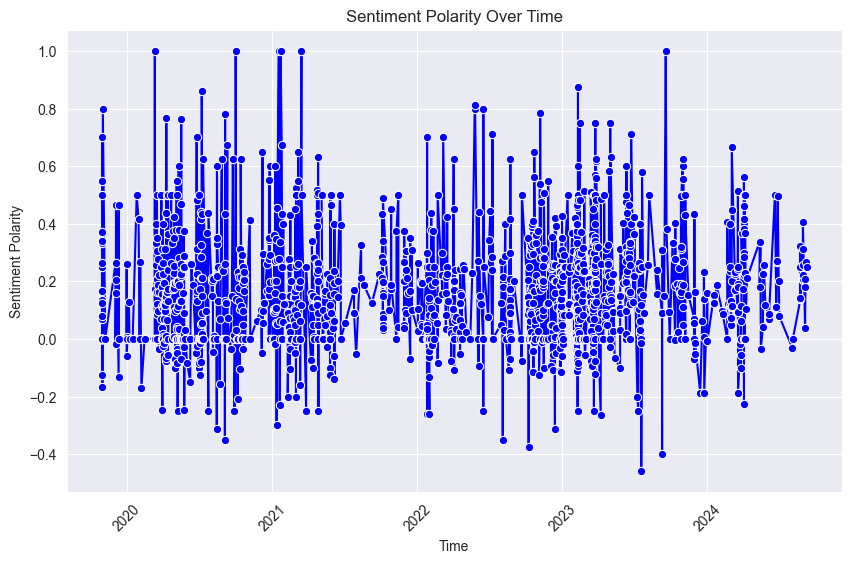

In [71]:
# Line plot for sentiment over time
plt.figure(figsize=(10,6))
sns.lineplot(x='created_at', y='sentiment_tb', data=df, marker='o', color='blue')
plt.title('Sentiment Polarity Over Time')
plt.xlabel('Time')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)
plt.show()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     1255 non-null   int64              
 1   created_at             1255 non-null   datetime64[ns, UTC]
 2   cooked                 1255 non-null   object             
 3   post_number            1255 non-null   int64              
 4   post_type              1255 non-null   int64              
 5   updated_at             1255 non-null   datetime64[ns, UTC]
 6   reply_count            1255 non-null   int64              
 7   reply_to_post_number   507 non-null    float64            
 8   quote_count            1255 non-null   int64              
 9   incoming_link_count    1255 non-null   int64              
 10  reads                  1255 non-null   int64              
 11  readers_count          1255 non-null   int64            

In [73]:
# selecting relevant numerical columns for correlation analysis
numerical_columns = ['reply_count', 'quote_count', 'incoming_link_count', 'reads', 'readers_count', 'score', 'category_id',
                     'post_length', 'sentiment_tb']

corr_matrix = df[numerical_columns].corr()

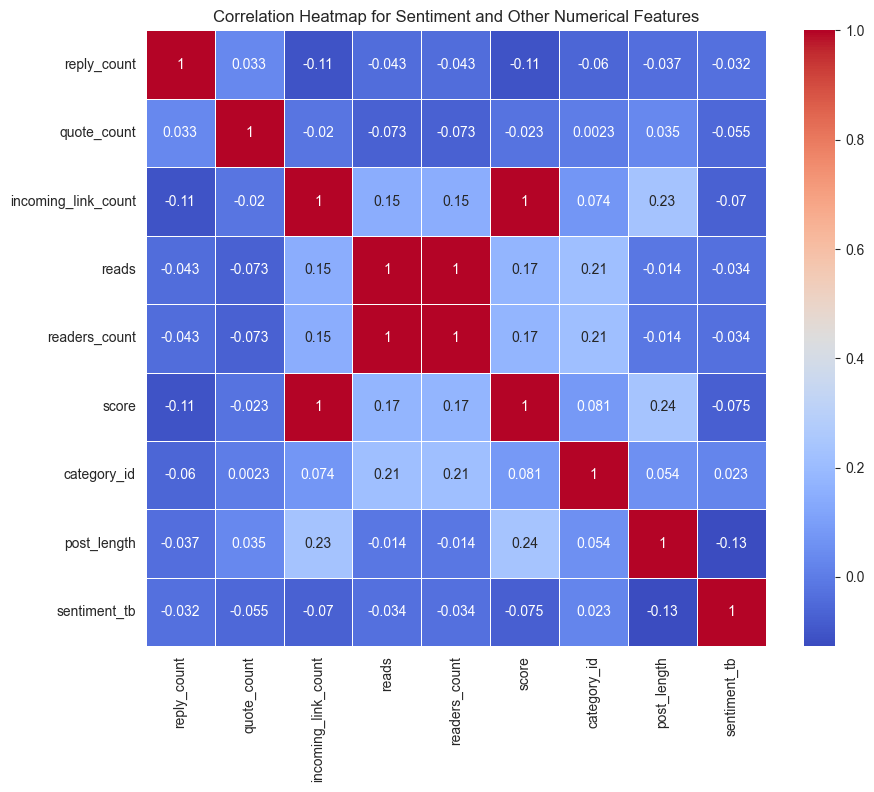

In [74]:
# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Sentiment and Other Numerical Features')
plt.show()